<a href="https://colab.research.google.com/github/dztaylor936/ds2025-group3/blob/main/Prophet_and_TS_RDB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import pandas_datareader as pdr
import yfinance as yf
import duckdb
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import itertools

In [3]:

# Read the Zillow CSV file into a pandas DataFrame
zillow = pd.read_csv("https://files.zillowstatic.com/research/public_csvs/zhvi/Neighborhood_zhvi_uc_sfrcondo_tier_0.33_0.67_sm_sa_month.csv?t=1742438344")

# Filter only the data for the city of Orlando, FL
orlando_zillow = zillow[zillow['City'] == 'Orlando']

orlando_zillow.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,2000-01-31,...,2024-05-31,2024-06-30,2024-07-31,2024-08-31,2024-09-30,2024-10-31,2024-11-30,2024-12-31,2025-01-31,2025-02-28
53,15046,53,Alafaya,neighborhood,FL,FL,Orlando,"Orlando-Kissimmee-Sanford, FL",Orange County,144927.749747,...,467159.267711,466849.121689,466408.444049,465899.561134,465776.317230,465097.054500,464410.376822,463606.685559,463030.958667,461993.795236
309,125257,324,Meadow Woods,neighborhood,FL,FL,Orlando,"Orlando-Kissimmee-Sanford, FL",Orange County,134759.030496,...,418406.484262,418335.060964,418447.183781,418495.559116,418558.203083,417947.871642,417013.660414,416016.557662,415103.647112,414335.116808
589,269087,619,Metro West,neighborhood,FL,FL,Orlando,"Orlando-Kissimmee-Sanford, FL",Orange County,96128.461535,...,248246.822394,246575.712581,244696.315115,242840.669341,240788.113033,238494.336464,236492.340386,235457.141847,234921.006268,234405.411206
844,124797,891,Hunters Creek,neighborhood,FL,FL,Orlando,"Orlando-Kissimmee-Sanford, FL",Orange County,168220.022649,...,488383.454921,488316.920760,488598.624039,488586.806303,488673.682417,488115.195448,487549.639736,486287.795463,484992.277800,483593.367352
1003,23566,1057,Azalea Park,neighborhood,FL,FL,Orlando,"Orlando-Kissimmee-Sanford, FL",Orange County,71158.669388,...,320065.281953,320515.247103,321195.627868,321838.552641,322063.171107,321406.976091,320932.267593,320426.971257,320043.402122,318950.162053


In [4]:
id_columns = [
    'RegionID', 'SizeRank', 'RegionName', 'RegionType',
    'StateName', 'State', 'City', 'Metro', 'CountyName'
]

orlando_long = orlando_zillow.melt(
    id_vars=id_columns,
    var_name='date',
    value_name='value'
)

# Convert the date column from string to datetime
orlando_long['date'] = pd.to_datetime(orlando_long['date'], errors='coerce')
orlando_long = orlando_long.sort_values(by='date')
# Now df_long is in long format
orlando_long.head()



,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,date,value
0,15046,53,Alafaya,neighborhood,FL,FL,Orlando,"Orlando-Kissimmee-Sanford, FL",Orange County,2000-01-31,144927.749747
80,269039,16639,Lake Formosa,neighborhood,FL,FL,Orlando,"Orlando-Kissimmee-Sanford, FL",Orange County,2000-01-31,144016.363541
79,268940,16633,Countryside,neighborhood,FL,FL,Orlando,"Orlando-Kissimmee-Sanford, FL",Orange County,2000-01-31,NaN
78,269052,16572,Lake Terrace,neighborhood,FL,FL,Orlando,"Orlando-Kissimmee-Sanford, FL",Orange County,2000-01-31,114515.673973
77,269166,16557,Rock Lake,neighborhood,FL,FL,Orlando,"Orlando-Kissimmee-Sanford, FL",Orange County,2000-01-31,55058.786770


In [5]:
print(orlando_long['date'].nunique(), "unique monthly dates")
print(orlando_long['RegionName'].nunique(), "unique regions")



302 unique monthly dates
110 unique regions


In [6]:
orlando_long['date'].min(), orlando_long['date'].max()

(Timestamp('2000-01-31 00:00:00'), Timestamp('2025-02-28 00:00:00'))

In [7]:
monthly_avg = orlando_long.groupby('date')['value'].mean()
print(monthly_avg)

date
2000-01-31    107826.675233
2000-02-29    108104.809799
2000-03-31    108521.265712
2000-04-30    109241.356396
2000-05-31    110026.972549
                  ...      
2024-10-31    414666.602311
2024-11-30    414443.175379
2024-12-31    414218.378452
2025-01-31    413978.387689
2025-02-28    413695.988165
Name: value, Length: 302, dtype: float64


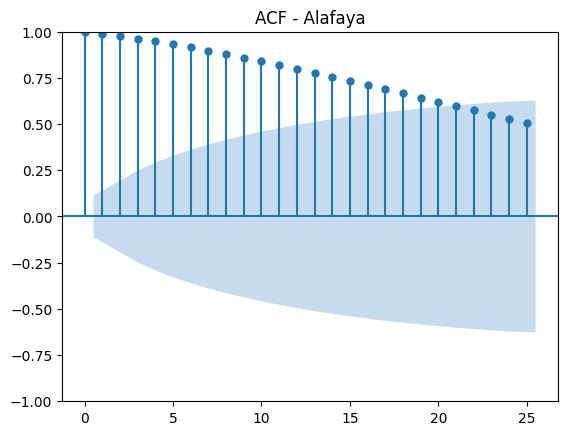

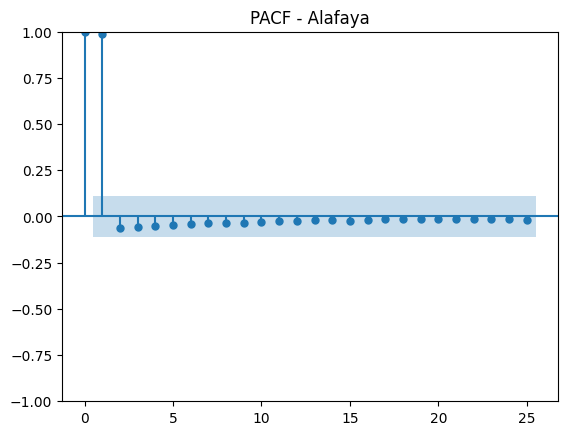

In [8]:
data_region = orlando_long[orlando_long["RegionName"] == "Alafaya"].copy()
data_region = data_region.sort_values("date")

# Convert date to a datetime if not already
data_region["date"] = pd.to_datetime(data_region["date"])

# Set date as index for easy plotting
data_region.set_index("date", inplace=True)
ts = data_region["value"]

# Plot ACF
plot_acf(ts)
plt.title("ACF - Alafaya")
plt.show()

# Plot PACF
plot_pacf(ts)
plt.title("PACF - Alafaya")
plt.show()

In [9]:
orlando_long = orlando_long.sort_values("date")

def adf_test(series):
    series = series.dropna()
    return adfuller(series)[1]  # ADF p-value

adf_results = (
    orlando_long
    .groupby("RegionName")["value"]
    .apply(adf_test)
    .reset_index(name="adf_pvalue")
)


adf_results1= adf_results.sort_values("adf_pvalue")
print(adf_results1)

orlando_long.head()



                    RegionName    adf_pvalue
18                 Countryside  6.927435e-26
68                  New Malibu  3.996378e-12
88                  South Eola  3.244337e-02
11   Central Business District  5.824190e-02
17                      Conway  5.938457e-02
..                         ...           ...
52             Lake Nona South  9.546268e-01
13                  Clear Lake  9.566725e-01
28                   East Park  9.588292e-01
61               Malibu Groves  9.869918e-01
105          Washington Shores  9.948672e-01

[110 rows x 2 columns]


,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,date,value
0,15046,53,Alafaya,neighborhood,FL,FL,Orlando,"Orlando-Kissimmee-Sanford, FL",Orange County,2000-01-31,144927.749747
54,269225,12209,Wedgewood Groves,neighborhood,FL,FL,Orlando,"Orlando-Kissimmee-Sanford, FL",Orange County,2000-01-31,94691.522910
1,125257,324,Meadow Woods,neighborhood,FL,FL,Orlando,"Orlando-Kissimmee-Sanford, FL",Orange County,2000-01-31,134759.030496
2,269087,619,Metro West,neighborhood,FL,FL,Orlando,"Orlando-Kissimmee-Sanford, FL",Orange County,2000-01-31,96128.461535
3,124797,891,Hunters Creek,neighborhood,FL,FL,Orlando,"Orlando-Kissimmee-Sanford, FL",Orange County,2000-01-31,168220.022649


In [10]:
orlando_long = orlando_long.sort_values(["RegionName", "date"]).reset_index(drop=True)

orlando_long["log_value"] = (
    orlando_long.groupby("RegionName")["value"]
          .transform(lambda x: np.log(x))
)

# 3. First difference of the values, per neighborhood
orlando_long["diff_value"] = (
    orlando_long.groupby("RegionName")["value"]
          .transform(lambda x: x.diff())
)



In [11]:
diff_1 = orlando_long.dropna(subset=["diff_value"])

# 5. Group by each RegionName, run the test on 'diff_value'
adf_results1 = (
    diff_1
    .groupby("RegionName")["diff_value"]
    .apply(adf_test)
    .reset_index(name="adf_pvalue_post_diff")
)

# 6. Inspect which neighborhoods are stationary after log+diff
print(adf_results1.head(50))

                   RegionName  adf_pvalue_post_diff
0               Airport North          1.115288e-01
1                     Alafaya          3.125944e-02
2                Audubon Park          2.816018e-01
3                 Azalea Park          1.940420e-01
4                Baldwin Park          4.618271e-02
5                     Bel Air          6.035486e-02
6                 Boggy Creek          1.309889e-01
7                   Bryn Mawr          5.214110e-02
8                    Callahan          1.540341e-01
9               Carver Shores          1.710688e-01
10                   Catalina          1.315357e-01
11  Central Business District          5.250813e-02
12       City of Orlando-GOAA          1.632515e-01
13                 Clear Lake          2.818630e-01
14               College Park          1.269604e-01
15         Colonialtown North          9.314436e-02
16         Colonialtown South          1.005158e-01
17                     Conway          9.764866e-02
18          

In [12]:
airport_data = orlando_long[orlando_long["RegionName"] == "Airport North"]
print(airport_data.head(10))
print("Non-missing count for 'value':", airport_data["value"].notna().sum())

   RegionID  SizeRank     RegionName    RegionType StateName State     City  \
0    268868      2398  Airport North  neighborhood        FL    FL  Orlando   
1    268868      2398  Airport North  neighborhood        FL    FL  Orlando   
2    268868      2398  Airport North  neighborhood        FL    FL  Orlando   
3    268868      2398  Airport North  neighborhood        FL    FL  Orlando   
4    268868      2398  Airport North  neighborhood        FL    FL  Orlando   
5    268868      2398  Airport North  neighborhood        FL    FL  Orlando   
6    268868      2398  Airport North  neighborhood        FL    FL  Orlando   
7    268868      2398  Airport North  neighborhood        FL    FL  Orlando   
8    268868      2398  Airport North  neighborhood        FL    FL  Orlando   
9    268868      2398  Airport North  neighborhood        FL    FL  Orlando   

                           Metro     CountyName       date  value  log_value  \
0  Orlando-Kissimmee-Sanford, FL  Orange County 20

In [13]:
log_1 = orlando_long.dropna(subset=["log_value"])


# 5. Group by each RegionName, run the test'
adf_results2 = (
    log_1
    .groupby("RegionName")["log_value"]
    .apply(adf_test)
    .reset_index(name="adf_pvalue_post_log")
)

# 6. Inspect which neighborhoods are stationary after log+diff
print(adf_results2.head(50))


orlando_long.head()

                   RegionName  adf_pvalue_post_log
0               Airport North         6.199660e-01
1                     Alafaya         5.311326e-01
2                Audubon Park         4.365411e-01
3                 Azalea Park         4.527507e-01
4                Baldwin Park         4.462235e-01
5                     Bel Air         4.761863e-01
6                 Boggy Creek         2.595846e-01
7                   Bryn Mawr         6.396333e-01
8                    Callahan         6.273806e-01
9               Carver Shores         8.189513e-01
10                   Catalina         3.610251e-01
11  Central Business District         2.832608e-02
12       City of Orlando-GOAA         8.284542e-01
13                 Clear Lake         6.761645e-01
14               College Park         4.295839e-01
15         Colonialtown North         6.622949e-01
16         Colonialtown South         5.268844e-01
17                     Conway         2.126494e-02
18                Countryside  

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,date,value,log_value,diff_value
0,268868,2398,Airport North,neighborhood,FL,FL,Orlando,"Orlando-Kissimmee-Sanford, FL",Orange County,2000-01-31,NaN,NaN,NaN
1,268868,2398,Airport North,neighborhood,FL,FL,Orlando,"Orlando-Kissimmee-Sanford, FL",Orange County,2000-02-29,NaN,NaN,NaN
2,268868,2398,Airport North,neighborhood,FL,FL,Orlando,"Orlando-Kissimmee-Sanford, FL",Orange County,2000-03-31,NaN,NaN,NaN
3,268868,2398,Airport North,neighborhood,FL,FL,Orlando,"Orlando-Kissimmee-Sanford, FL",Orange County,2000-04-30,NaN,NaN,NaN
4,268868,2398,Airport North,neighborhood,FL,FL,Orlando,"Orlando-Kissimmee-Sanford, FL",Orange County,2000-05-31,NaN,NaN,NaN


In [14]:
# Third test: Sqrt, Diff+ log, Diff 2x

orlando_long = orlando_long.sort_values(["RegionName", "date"]).reset_index(drop=True)

orlando_long["sqrt_value"] = (
    orlando_long.groupby("RegionName")["value"]
          .transform(lambda x: np.sqrt(x))
)

# 3. First difference of the logged values, per neighborhood
orlando_long["diff_value"] = (
    orlando_long.groupby("RegionName")["log_value"]
          .transform(lambda x: x.diff())
)

orlando_long["diff_value2"] = (
    orlando_long.groupby("RegionName")["diff_value"]
          .transform(lambda x: x.diff())
)
sqrt_1 = orlando_long.dropna(subset=["sqrt_value"])
diff_1 = orlando_long.dropna(subset=["diff_value"])
diff_2 = orlando_long.dropna(subset=["diff_value2"])


In [15]:

# 5. Group by each RegionName, run the test on 'sqrt_value'
adf_results3 = (
    sqrt_1
    .groupby("RegionName")["sqrt_value"]
    .apply(adf_test)
    .reset_index(name="adf_pvalue_post_sqrt")
)

# 6. Inspect which neighborhoods are stationary after sqrt
print(adf_results3.head(50))


# 5. Group by each RegionName, run the test on log+diff
adf_results4 = (
    diff_1
    .groupby("RegionName")["diff_value"]
    .apply(adf_test)
    .reset_index(name="adf_pvalue_post_log&diff")
)

# 6. Inspect which neighborhoods are stationary after log+diff
print(adf_results4.head(50))


# 5. Group by each RegionName, run the test on Second diff
adf_results5 = (
    diff_2
    .groupby("RegionName")["diff_value2"]
    .apply(adf_test)
    .reset_index(name="adf_pvalue_post_2ndDiff")
)

# 6. Inspect which neighborhoods are stationary after second diff
print(adf_results5.head(50))








                   RegionName  adf_pvalue_post_sqrt
0               Airport North          6.312272e-01
1                     Alafaya          6.389396e-01
2                Audubon Park          5.135260e-01
3                 Azalea Park          5.661703e-01
4                Baldwin Park          6.110204e-01
5                     Bel Air          6.321904e-01
6                 Boggy Creek          3.322456e-01
7                   Bryn Mawr          6.959198e-01
8                    Callahan          7.894714e-01
9               Carver Shores          8.722645e-01
10                   Catalina          5.298531e-01
11  Central Business District          3.721225e-02
12       City of Orlando-GOAA          8.377385e-01
13                 Clear Lake          8.348616e-01
14               College Park          5.515825e-01
15         Colonialtown North          7.274857e-01
16         Colonialtown South          6.216815e-01
17                     Conway          3.551859e-02
18          

In [16]:
adf_results5= adf_results5.sort_values("adf_pvalue_post_2ndDiff", ascending= False)

print(adf_results5)


                    RegionName  adf_pvalue_post_2ndDiff
18                 Countryside             9.989830e-01
77                 Randal Park             2.844450e-01
11   Central Business District             7.563582e-02
76                    Pineloch             2.963154e-02
60                    Lockhart             2.415455e-02
..                         ...                      ...
2                 Audubon Park             3.573912e-13
9                Carver Shores             3.114054e-13
83                   Rose Isle             2.061232e-13
35              Holden Heights             1.641193e-13
106           Wedgewood Groves             3.720256e-17

[110 rows x 2 columns]


In [22]:
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Define an evaluation function for the test set forecast
def evaluate_forecast(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100  # expressed as percentage
    return {"MAE": mae, "RMSE": rmse, "MAPE": mape}

# Ensure your date column is in datetime format and rename columns for Prophet
orlando_long["ds"] = pd.to_datetime(orlando_long["date"])
orlando_long = orlando_long.rename(columns={'value': 'y'})

# Define a cutoff date for training/test split (adjust as needed)
cutoff_date = "2023-01-01"

# Container to hold results for each neighborhood
results = []

# Loop over each neighborhood (using "RegionName")
for region, group_df in orlando_long.groupby("RegionName"):
    # Sort by date (the "ds" column)
    group_df = group_df.sort_values("ds")

    # Split the data: training before cutoff, test starting from cutoff
    train_df = group_df[group_df["ds"] < cutoff_date].copy()
    test_df  = group_df[group_df["ds"] >= cutoff_date].copy()

    # Skip neighborhoods with insufficient training or testing data
    if train_df["y"].notna().sum() < 2 or test_df["y"].notna().sum() < 1:
        print(f"Skipping {region} due to insufficient data: "
              f"train count = {train_df['y'].notna().sum()}, "
              f"test count = {test_df['y'].notna().sum()}")
        continue

    # Fit Prophet on the training data
    m = Prophet()
    try:
        m.fit(train_df)
    except Exception as e:
        print(f"Error fitting Prophet for {region}: {e}")
        continue

    # --- Evaluate on Test Data ---
    # Create a future dataframe covering the test period (same number of periods as in test)
    future_test = m.make_future_dataframe(periods=len(test_df), freq="M")
    forecast_test = m.predict(future_test)

    # Select only the forecasted values in the test period (using the cutoff date)
    forecast_test = forecast_test[forecast_test["ds"] >= cutoff_date]
    y_true = test_df["y"].values
    y_pred = forecast_test["yhat"].values
    metrics_dict = evaluate_forecast(y_true, y_pred)

    # --- Forecast 5 years into the future ---
    future_5yr = m.make_future_dataframe(periods=60, freq="M")
    forecast_5yr = m.predict(future_5yr)

    # --- Forecast 10 Years into the Future ---
    future_10yr = m.make_future_dataframe(periods=120, freq="M")
    forecast_10yr = m.predict(future_10yr)

    # --- Forecast 15 Years into the Future ---

    future_15yr = m.make_future_dataframe(periods=180, freq="M")
    forecast_15yr = m.predict(future_15yr)

    # Collect results for the current region
    results.append({
        "RegionName": region,
        "metrics": metrics_dict,
        "forecast_test": forecast_test,
        "forecast_5yr": forecast_5yr,
        "forecast_10yr": forecast_10yr,     # Full forecast including history plus 10 years
        "forecast_15yr": forecast_15yr      # Full forecast including history plus 15 years
    })

# Convert the results list to a DataFrame of metrics (for summary, if desired)
metrics_df = pd.DataFrame([{"RegionName": r["RegionName"], **r["metrics"]} for r in results])
print("Evaluation Metrics:")
print(metrics_df.sort_values("MAE").head(10))


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7p7yab9t/word5vx4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7p7yab9t/r6gye3xx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90878', 'data', 'file=/tmp/tmp7p7yab9t/word5vx4.json', 'init=/tmp/tmp7p7yab9t/r6gye3xx.json', 'output', 'file=/tmp/tmp7p7yab9t/prophet_model2bs4enpt/prophet_model-20250413204429.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:44:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:44:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/

Skipping Countryside due to insufficient data: train count = 0, test count = 15


/usr/local/lib/python3.11/dist-packages/prophet/forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(
/usr/local/lib/python3.11/dist-packages/prophet/forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(
/usr/local/lib/python3.11/dist-packages/prophet/forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(
/usr/local/lib/python3.11/dist-packages/prophet/forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile

Skipping New Malibu due to insufficient data: train count = 0, test count = 15


/usr/local/lib/python3.11/dist-packages/prophet/forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(
/usr/local/lib/python3.11/dist-packages/prophet/forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(
/usr/local/lib/python3.11/dist-packages/prophet/forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(
/usr/local/lib/python3.11/dist-packages/prophet/forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile

Evaluation Metrics:
            RegionName          MAE         RMSE      MAPE
105      West Colonial  4469.701822  5188.926923  1.944782
63         Mercy Drive  4708.319961  6078.145090  2.173278
42           Lake Como  6500.055285  9548.702937  1.413612
79           Rock Lake  6572.404958  7609.852957  2.200335
3          Azalea Park  6599.750106  8324.624948  2.116681
26   East Central Park  6628.505778  8180.797270  1.898879
18             Coytown  6731.205493  8277.284206  1.642764
77    Richmond Heights  6896.126206  9537.172932  2.881574
76    Richmond Estates  6963.414448  8353.073347  2.932196
29     Fairview Shores  7073.380505  8023.479072  2.186650


In [ ]:
# Specific region, for example:
region_example = "Alafaya"
for r in results:
    if r["RegionName"] == region_example:
        model_forecast_10yr = r["forecast_10yr"]
        model_forecast_15yr = r["forecast_15yr"]
        print(f"\nForecast for {region_example} (5 years):")
        print(model_forecast_5yr.tail(10))  # show last 10 forecasted records
        print(f"\nForecast for {region_example} (10 years):")
        print(model_forecast_10yr.tail(10))  # show last 10 forecasted records
        print(f"\nForecast for {region_example} (15 years):")
        print(model_forecast_15yr.tail(10))
        break


Forecast for Alafaya (10 years):
            ds          trend     yhat_lower     yhat_upper    trend_lower  \
386 2032-03-31  695630.611322  477457.069340  898870.801735  485734.737662   
387 2032-04-30  698184.238863  485465.994938  907441.777261  485978.863874   
388 2032-05-31  700822.987322  485006.811219  912384.277524  487096.679828   
389 2032-06-30  703376.614863  484961.285980  920945.069907  488112.111480   
390 2032-07-31  706015.363322  487532.922867  918961.296921  488933.996602   
391 2032-08-31  708654.111781  483603.493748  925576.576267  487661.005148   
392 2032-09-30  711207.739322  481726.330377  935221.098006  486582.133779   
393 2032-10-31  713846.487781  483436.788902  938138.136508  486502.511634   
394 2032-11-30  716400.115322  482348.605104  942136.377561  484025.204153   
395 2032-12-31  719038.863781  477942.342699  946207.115614  484894.429301   

       trend_upper  additive_terms  additive_terms_lower  \
386  898856.393440     -770.405266           -7

In [23]:
orlando_long["ds"] = pd.to_datetime(orlando_long["date"])
orlando_long = orlando_long.rename(columns={'value': 'y'})

# This container will hold our ranking results for each neighborhood.
results_forecast = []

# Loop over each neighborhood
for region, group_df in orlando_long.groupby("RegionName"):
    # Sort by date (required for Prophet)
    group_df = group_df.sort_values("ds")

    if group_df["y"].notna().sum() < 2:
        print(f"Skipping {region} due to insufficient data.")
        continue

    # Fit Prophet on the full historical data for the region
    m = Prophet()
    try:
        m.fit(group_df)
    except Exception as e:
        print(f"Error fitting Prophet for {region}: {e}")
        continue


    # 5 years
    future_5yr = m.make_future_dataframe(periods=60, freq="M")
    forecast_5yr = m.predict(future_5yr)

    # 10 years is 10 * 12 = 120 periods.
    future_10yr = m.make_future_dataframe(periods=120, freq="M")
    forecast_10yr = m.predict(future_10yr)

    #Final row with 5
    final_forecast_5yr = forecast_5yr.iloc[-1]
    final_date_5yr = final_forecast_5yr["ds"]
    final_value_5yr = final_forecast_5yr["yhat"]

    # The final row of the forecast represents ~10 years from your latest observation.
    final_forecast_10yr = forecast_10yr.iloc[-1]
    final_date_10yr = final_forecast_10yr["ds"]
    final_value_10yr = final_forecast_10yr["yhat"]

    future_15yr = m.make_future_dataframe(periods=180, freq="M")
    forecast_15yr = m.predict(future_15yr)
    final_forecast_15yr = forecast_15yr.iloc[-1]
    final_date_15yr = final_forecast_15yr["ds"]
    final_value_15yr = final_forecast_15yr["yhat"]

    # Store the results for this region:
    results_forecast.append({
        "RegionName": region,
        "ProjectedValue_5yr": final_value_5yr,
        "FinalForecastDate_5yr": final_date_5yr,
        "ProjectedValue_10yr": final_value_10yr,
        "FinalForecastDate_10yr": final_date_10yr,
        "ProjectedValue_15yr": final_value_15yr,
        "FinalForecastDate_15yr": final_date_15yr,
    })

# Convert the list of dictionaries to a DataFrame and rank
rankings_df = pd.DataFrame(results_forecast)

# Rank neighborhoods by their 10-year projected value (descending order)
rankings_df = rankings_df.sort_values("ProjectedValue_10yr", ascending=False)

print("Ranked Neighborhoods by Projected 10-Year Value:")
print(rankings_df.head(20))


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7p7yab9t/gf4816lp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7p7yab9t/xegopxf2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46747', 'data', 'file=/tmp/tmp7p7yab9t/gf4816lp.json', 'init=/tmp/tmp7p7yab9t/xegopxf2.json', 'output', 'file=/tmp/tmp7p7yab9t/prophet_model9y70bd11/prophet_model-20250413204801.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:48:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:48:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/

Ranked Neighborhoods by Projected 10-Year Value:
                     RegionName  ProjectedValue_5yr FinalForecastDate_5yr  \
51            Lake Nona Estates        3.801025e+06            2030-02-28   
83                    Rose Isle        2.108329e+06            2030-02-28   
58               Lancaster Park        1.223087e+06            2030-02-28   
72                  Orwin Manor        1.184033e+06            2030-02-28   
92                Southern Oaks        1.133052e+06            2030-02-28   
4                  Baldwin Park        1.128817e+06            2030-02-28   
94                  Spring Lake        1.055503e+06            2030-02-28   
5                       Bel Air        1.022053e+06            2030-02-28   
21                 Delaney Park        1.034915e+06            2030-02-28   
86               Rowena Gardens        9.672268e+05            2030-02-28   
75           Park Lake-Highland        8.596932e+05            2030-02-28   
70  Northlake Park at Lake 

In [24]:
orlando_long["ds"] = pd.to_datetime(orlando_long["date"])
orlando_long = orlando_long.rename(columns={'value': 'y'})

# Container for our regional forecast summaries.
forecast_results = []

# Loop through each neighborhood
for region, group_df in orlando_long.groupby("RegionName"):
    # Sort the group by date (ascending order)
    group_df = group_df.sort_values("ds")

    # Get the most recent (current) value
    # We assume the last recorded observation is the current value.
    if group_df["y"].dropna().empty:
        # Skip if no valid historical value available.
        continue
    current_value = group_df["y"].dropna().iloc[-1]

    # Fit a Prophet model for the full history of this region.
    m = Prophet()
    try:
        m.fit(group_df)
    except Exception as e:
        print(f"Error fitting Prophet for region '{region}': {e}")
        continue

    # Forecast horizons (for monthly data):
    periods_5yr  = 60   # 5 years * 12 months per year
    periods_10yr = 120  # 10 years * 12
    periods_15yr = 180  # 15 years * 12

    # Create future dataframes
    future_5yr  = m.make_future_dataframe(periods=periods_5yr, freq="M")
    future_10yr = m.make_future_dataframe(periods=periods_10yr, freq="M")
    future_15yr = m.make_future_dataframe(periods=periods_15yr, freq="M")

    # Generate forecasts
    forecast_5yr  = m.predict(future_5yr)
    forecast_10yr = m.predict(future_10yr)
    forecast_15yr = m.predict(future_15yr)

    # The final forecast row from each horizon gives the projection at that future endpoint.
    final_5yr_value  = forecast_5yr.iloc[-1]["yhat"]
    final_10yr_value = forecast_10yr.iloc[-1]["yhat"]
    final_15yr_value = forecast_15yr.iloc[-1]["yhat"]

    # Compute absolute changes (forecasted value minus current value)
    abs_change_5yr  = final_5yr_value  - current_value
    abs_change_10yr = final_10yr_value - current_value
    abs_change_15yr = final_15yr_value - current_value

    # Compute percentage change ((forecast / current) - 1) * 100
    pct_change_5yr  = ((final_5yr_value  / current_value) - 1) * 100
    pct_change_10yr = ((final_10yr_value / current_value) - 1) * 100
    pct_change_15yr = ((final_15yr_value / current_value) - 1) * 100

    # Collect the results for this region
    forecast_results.append({
        "RegionName": region,
        "CurrentValue": current_value,
        "ForecastValue_5yr": final_5yr_value,
        "AbsChange_5yr": abs_change_5yr,
        "PctChange_5yr": pct_change_5yr,
        "ForecastValue_10yr": final_10yr_value,
        "AbsChange_10yr": abs_change_10yr,
        "PctChange_10yr": pct_change_10yr,
        "ForecastValue_15yr": final_15yr_value,
        "AbsChange_15yr": abs_change_15yr,
        "PctChange_15yr": pct_change_15yr
    })

# Convert the list of dictionaries to a DataFrame
forecast_df = pd.DataFrame(forecast_results)

# Now rank the neighborhoods by any measure—for instance, by percentage change at 5 years.
ranked_by_pct_5yr = forecast_df.sort_values("PctChange_5yr", ascending=False)

# Display the top 20 (you can adjust based on your requirement)
print("Top 20 Neighborhoods by Percentage Change (5-year forecast):")
print(ranked_by_pct_5yr[[
    "RegionName",
    "CurrentValue",
    "ForecastValue_5yr",
    "AbsChange_5yr",
    "PctChange_5yr"
]].head(20))

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7p7yab9t/x8x_3z7y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7p7yab9t/vosm6ool.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64913', 'data', 'file=/tmp/tmp7p7yab9t/x8x_3z7y.json', 'init=/tmp/tmp7p7yab9t/vosm6ool.json', 'output', 'file=/tmp/tmp7p7yab9t/prophet_modelgwy_z8vm/prophet_model-20250413205502.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:55:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:55:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/

Top 20 Neighborhoods by Percentage Change (5-year forecast):
                      RegionName  CurrentValue  ForecastValue_5yr  \
35                Holden Heights  2.076331e+05       3.376746e+05   
38               Johnson Village  2.104308e+05       3.398926e+05   
8                       Callahan  1.999030e+05       3.216492e+05   
80               Rio Grande Park  2.061535e+05       3.310124e+05   
100                   Timberleaf  2.839698e+05       4.522862e+05   
64                   Mercy Drive  2.276129e+05       3.611210e+05   
9                  Carver Shores  2.235251e+05       3.533429e+05   
49             Lake Mann Estates  2.417558e+05       3.809901e+05   
90                 South Semoran  1.665223e+05       2.623599e+05   
36              Holden-Parramore  2.138290e+05       3.350751e+05   
74                  Park Central  1.738587e+05       2.719276e+05   
61                 Malibu Groves  2.166423e+05       3.384239e+05   
51             Lake Nona Estates  2.442820

In [28]:
from IPython.display import display

# Let's take the top 20 entries:
top20 = ranked_by_pct_5yr.head(20)

# Use the pandas Styler to format the numbers and add visual bars
styled_top20 = (top20[['RegionName', 'CurrentValue', 'ForecastValue_5yr', 'AbsChange_5yr', 'PctChange_5yr']]
                .style
                .format({
                    'CurrentValue': "${:,.2f}",
                    'ForecastValue_5yr': "${:,.2f}",
                    'AbsChange_5yr': "${:,.2f}",
                    'PctChange_5yr': "{:.1f}%"
                })
                # Add a background gradient (or bar) to visually compare percentage changes
                .bar(subset=['PctChange_5yr'], color='darkgreen')
                .set_caption("Top 20 Neighborhoods by 5-Year Forecast Percentage Change")
               )

display(styled_top20)

,RegionName,CurrentValue,ForecastValue_5yr,AbsChange_5yr,PctChange_5yr
35,Holden Heights,"$207,633.14","$337,674.62","$130,041.47",62.6%
38,Johnson Village,"$210,430.82","$339,892.64","$129,461.81",61.5%
8,Callahan,"$199,902.98","$321,649.17","$121,746.19",60.9%
80,Rio Grande Park,"$206,153.46","$331,012.35","$124,858.89",60.6%
100,Timberleaf,"$283,969.84","$452,286.18","$168,316.34",59.3%
64,Mercy Drive,"$227,612.86","$361,121.03","$133,508.16",58.7%
9,Carver Shores,"$223,525.05","$353,342.87","$129,817.81",58.1%
49,Lake Mann Estates,"$241,755.76","$380,990.05","$139,234.29",57.6%
90,South Semoran,"$166,522.34","$262,359.89","$95,837.55",57.6%
36,Holden-Parramore,"$213,829.04","$335,075.13","$121,246.09",56.7%


In [19]:
conn = duckdb.connect('ds2025-group3.duckdb')

# Create tables with normalization (example)
conn.register("orlando_long_view", orlando_long)


conn.execute("""
    CREATE TABLE IF NOT EXISTS regions AS
    SELECT DISTINCT
        RegionID,
        SizeRank,
        RegionName,
        RegionType,
        StateName,
        State,
        City,
        Metro,
        CountyName
    FROM orlando_long_view
""")

# Create a table for the time series observations.
conn.execute("""
    DROP TABLE IF EXISTS observations;
    CREATE TABLE IF NOT EXISTS observations AS
    SELECT
        RegionID,  -- foreign key to regions
        RegionName,  -- foreign key to regions
         ds AS date,
        y as value      -- actual value
    FROM orlando_long_view
""")


sample_data = conn.execute("SELECT * FROM observations LIMIT 75").fetchdf()
print(sample_data)

    RegionID     RegionName       date          value
0     268868  Airport North 2000-01-31            NaN
1     268868  Airport North 2000-02-29            NaN
2     268868  Airport North 2000-03-31            NaN
3     268868  Airport North 2000-04-30            NaN
4     268868  Airport North 2000-05-31            NaN
..       ...            ...        ...            ...
70    268868  Airport North 2005-11-30  167149.404117
71    268868  Airport North 2005-12-31  168226.351542
72    268868  Airport North 2006-01-31  169204.611378
73    268868  Airport North 2006-02-28  170508.131394
74    268868  Airport North 2006-03-31  172191.849275

[75 rows x 4 columns]


In [20]:
query = """
SELECT RegionName, date, value
 FROM observations
 where RegionName = 'Alafaya'
 ORDER BY date
"""

df_observations = conn.execute(query).fetchdf()

# Print the results as a Pandas DataFrame
print(df_observations)

    RegionName       date          value
0      Alafaya 2000-01-31  144927.749747
1      Alafaya 2000-02-29  145248.433536
2      Alafaya 2000-03-31  145785.241866
3      Alafaya 2000-04-30  146673.764034
4      Alafaya 2000-05-31  147710.937540
..         ...        ...            ...
297    Alafaya 2024-10-31  465097.054500
298    Alafaya 2024-11-30  464410.376822
299    Alafaya 2024-12-31  463606.685559
300    Alafaya 2025-01-31  463030.958667
301    Alafaya 2025-02-28  461993.795236

[302 rows x 3 columns]
